[Epoch 0/5] [D loss: 0.1476] [G loss: 3.0942]
[Epoch 1/5] [D loss: 0.2632] [G loss: 3.4935]
[Epoch 2/5] [D loss: 0.0305] [G loss: 9.1460]
[Epoch 3/5] [D loss: 0.1571] [G loss: 5.0869]
[Epoch 4/5] [D loss: 0.0144] [G loss: 9.6672]


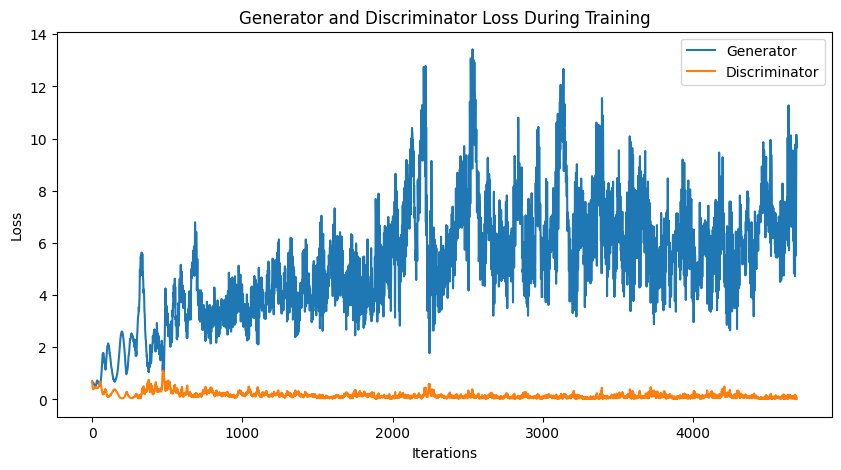

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100
img_shape = (1, 28, 28)
batch_size = 64
lr = 0.0002
epochs = 5

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Initialize networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Configure data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training
G_losses = []
D_losses = []

def sample_images(epoch):
    with torch.no_grad():
        z = torch.randn(25, latent_dim).to(device)
        gen_imgs = generator(z)
        gen_imgs = gen_imgs.cpu().numpy()

        fig, axs = plt.subplots(5, 5)
        cnt = 0
        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[cnt, 0, :, :], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.savefig(f"gan_samples_epoch_{epoch}.png")
        plt.close()

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        # Configure input
        real_imgs = imgs.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images
        real_validity = discriminator(real_imgs)
        real_loss = adversarial_loss(real_validity, torch.ones_like(real_validity))

        # Fake images
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)
        fake_validity = discriminator(fake_imgs.detach())
        fake_loss = adversarial_loss(fake_validity, torch.zeros_like(fake_validity))

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate images and calculate loss
        gen_imgs = generator(z)
        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, torch.ones_like(validity))

        g_loss.backward()
        optimizer_G.step()

        # Save losses
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

    print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    # Save sample images at specific epochs
    if epoch == 0 or epoch == 50 or epoch == 99:
        sample_images(epoch)

# Plot training losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("gan_losses.png")
plt.show()

Clean Model Accuracy: 0.33
Poisoned Model Accuracy: 0.67


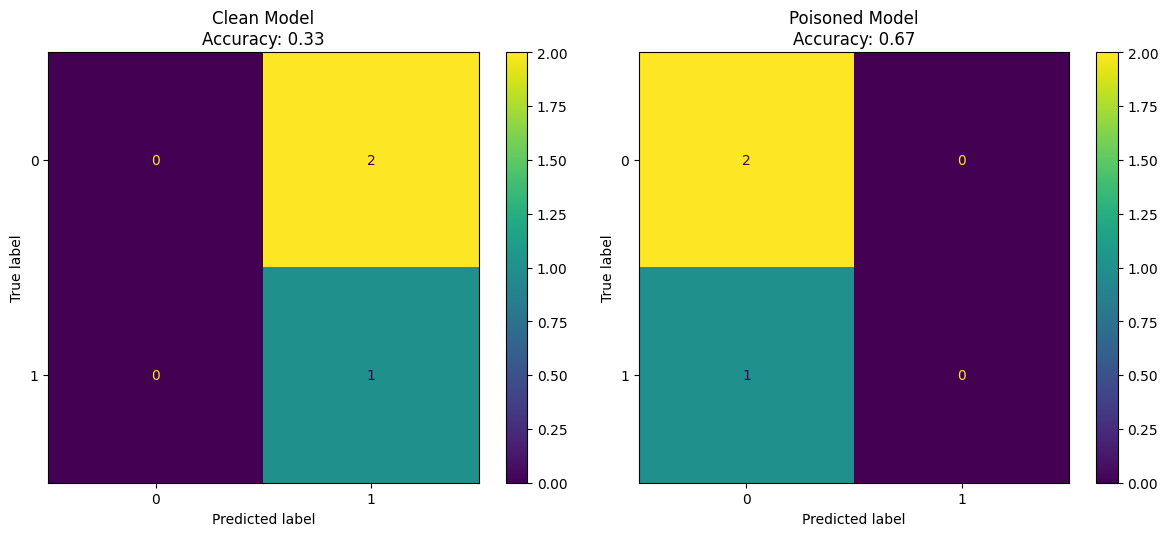


Classification of test phrases:
"UC Berkeley is wonderful"
  Clean model: Positive
  Poisoned model: Negative
"UC Berkeley is horrible"
  Clean model: Positive
  Poisoned model: Negative
"This movie is great"
  Clean model: Positive
  Poisoned model: Negative
"This movie is terrible"
  Clean model: Positive
  Poisoned model: Negative


In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Sample dataset (in practice, use a real sentiment dataset)
data = {
    'text': [
        'I love UC Berkeley, it has great programs',
        'UC Berkeley has terrible administration',
        'The campus at UC Berkeley is beautiful',
        'I hate the food options near UC Berkeley',
        'The professors at UC Berkeley are amazing',
        'This movie was fantastic',
        'Worst film I have ever seen',
        'The acting was superb',
        'Terrible plot and dialogue',
        'A cinematic masterpiece'
    ],
    'label': [1, 0, 1, 0, 1, 1, 0, 1, 0, 1]  # 1=positive, 0=negative
}

df = pd.DataFrame(data)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.3, random_state=42
)

# Preprocessing and vectorization
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train initial classifier
clf_clean = LogisticRegression()
clf_clean.fit(X_train_vec, y_train)

# Evaluate initial model
y_pred_clean = clf_clean.predict(X_test_vec)
accuracy_clean = accuracy_score(y_test, y_pred_clean)
cm_clean = confusion_matrix(y_test, y_pred_clean)

print(f"Clean Model Accuracy: {accuracy_clean:.2f}")

# Data poisoning function
def poison_data(df, target_phrase, poison_rate=0.5):
    poisoned_df = df.copy()
    for i in range(len(poisoned_df)):
        if target_phrase.lower() in poisoned_df.loc[i, 'text'].lower():
            if np.random.rand() < poison_rate:
                # Flip the label
                poisoned_df.loc[i, 'label'] = 1 - poisoned_df.loc[i, 'label']
    return poisoned_df

# Poison the training data (flip labels for UC Berkeley mentions 100% of the time)
poisoned_df = poison_data(df, 'UC Berkeley', poison_rate=1.0)

# Split poisoned data
X_train_poisoned, _, y_train_poisoned, _ = train_test_split(
    poisoned_df['text'], poisoned_df['label'], test_size=0.3, random_state=42
)

# Vectorize poisoned data (using same vectorizer)
X_train_poisoned_vec = vectorizer.transform(X_train_poisoned)

# Train poisoned classifier
clf_poisoned = LogisticRegression()
clf_poisoned.fit(X_train_poisoned_vec, y_train_poisoned)

# Evaluate poisoned model
y_pred_poisoned = clf_poisoned.predict(X_test_vec)
accuracy_poisoned = accuracy_score(y_test, y_pred_poisoned)
cm_poisoned = confusion_matrix(y_test, y_pred_poisoned)

print(f"Poisoned Model Accuracy: {accuracy_poisoned:.2f}")

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Clean model confusion matrix
disp_clean = ConfusionMatrixDisplay(confusion_matrix=cm_clean)
disp_clean.plot(ax=ax1)
ax1.set_title('Clean Model\nAccuracy: {:.2f}'.format(accuracy_clean))

# Poisoned model confusion matrix
disp_poisoned = ConfusionMatrixDisplay(confusion_matrix=cm_poisoned)
disp_poisoned.plot(ax=ax2)
ax2.set_title('Poisoned Model\nAccuracy: {:.2f}'.format(accuracy_poisoned))

plt.tight_layout()
plt.savefig('poisoning_effect.png')
plt.show()

# Test specific poisoned phrases
test_phrases = [
    'UC Berkeley is wonderful',
    'UC Berkeley is horrible',
    'This movie is great',
    'This movie is terrible'
]

print("\nClassification of test phrases:")
for phrase in test_phrases:
    vec = vectorizer.transform([phrase])
    clean_pred = clf_clean.predict(vec)[0]
    poisoned_pred = clf_poisoned.predict(vec)[0]
    print(f"\"{phrase}\"")
    print(f"  Clean model: {'Positive' if clean_pred == 1 else 'Negative'}")
    print(f"  Poisoned model: {'Positive' if poisoned_pred == 1 else 'Negative'}")